### This is for the Analysis for Bias Adjusted Precipitation data of CMIP6 GCMs

In [78]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import KNN
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import glob
import os
import yaml
import data.helper as helper

In [106]:
## load inputs
test_period = [1979, 2000]
exps  = ['d2d216d0', '978faac3']
testep = [50, 50]
ref_eval = '978faac3' #which reference data to be used
compare_methods = []

In [107]:
def load_model_run(run_id, est_period, epoch=None, base_dir='/pscratch/sd/k/kas7897/diffDownscale/jobs'):
    run_path = helper.load_run_path(run_id, base_dir)

    flat_dir = os.path.join(run_path, f"{test_period[0]}_{test_period[1]}")

    # Check which structure exists
    data_path = flat_dir
    config_path = os.path.join(run_path, 'train_config.yaml')

    x = torch.load(os.path.join(data_path, 'x.pt'), map_location='cpu').squeeze(-1).numpy()
    y = torch.load(os.path.join(data_path, 'y.pt'), map_location='cpu').squeeze(-1).numpy()
    time = torch.load(os.path.join(data_path, 'time.pt'), map_location='cpu')

    xt = None
    if epoch is not None:
        xt_path = os.path.join(data_path, f'ep{epoch}', 'xt.pt')
        if os.path.exists(xt_path):
            xt = torch.load(xt_path, map_location='cpu')

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    return {
        'run_path': run_path,
        'x': x,
        'y': y,
        'time': time,
        'xt': xt,
        'config': config
    }

models = []
for i in range(len(exps)):
    model = load_model_run(exps[i], test_period, epoch=testep[i])
    models.append(model)



In [108]:
method_names = []

for i, model in enumerate(models):
    config = model['config']
    
    ref = config['ref']
    degree = config['degree']
    emph_quantile = config['emph_quantile']
    time_scale = config['time_scale']
    ep = testep[i]

    method_name = f"delCLIMAD-BA({ref}_degree{degree}_quantile{emph_quantile}_ep{ep}_{time_scale})"
    method_names.append(method_name)


method_names = method_names + compare_methods

cmip6_dir = models[0]['config']['cmip_dir']
clim = models[0]['config']['clim']
ref = models[0]['config']['ref']
ref_var = models[0]['config']['ref_var']
shapefile_path = None if not  models[0]['config']['spatial_test']  else models[0]['config']['shapefile_filter_path']
train_period = [models[0]['config']['train_start'], models[0]['config']['train_end']]

try:
    spatial_extent = models[0]['config']['spatial_extent_test']
except:
    spatial_extent = models[0]['config']['spatial_extent_val']


ds_sample = xr.open_dataset(f"{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc")
valid_coords = valid_crd.valid_lat_lon(ds_sample, var_name='pr', shapefile_path=shapefile_path, attrList=spatial_extent)

In [109]:

## Loading competitors
if 'LOCA' in method_names:
    loca = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/loca/coarse_USclip.nc')
    loca = loca['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
                                        lon=xr.DataArray(valid_coords[:, 1], dims='points'),
                                        method='nearest')
    loca = loca.sel(time =slice(f'{test_period[0]}', f'{test_period[1]}')).values

    #unit conversion
    loca = loca*86400




if 'QM' in method_names:
    QM_bench = f'benchmark/QuantileMapping/conus/{clim}-{ref}/{train_period}_historical_{test_period}.pt'
    QM_debiased = torch.load(QM_bench, weights_only=False).squeeze(-1)
    QM_debiased = QM_debiased*86400

In [110]:
## this block filters 'y' based on 'x' calender
for model in models:
    time = model['time']
    
    x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
    x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
    # Generate a daily time array following the standard Gregorian calendar
    y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

    # Convert to NumPy array for indexing and comparison
    y_time_np = y_time.to_numpy()

    # Find indices where observed time matches model time
    matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

    model['y'] = model['y'][matched_indices,:]
    model['x_time_np'] = x_time_np

    # loca = loca[matched_indices, :]

In [111]:

# Initialize climate indices manager
climate_indices = ClimateIndices()

ref_eval_data = models[exps.index(ref_eval)]['y']

mean_bias_percentage = []
day_bias_percentage = []
for model in models:
    day_bias_percentage.append(get_day_bias_percentages(model['x'], ref_eval_data, model['xt'], climate_indices))
    mean_bias_percentage.append(get_mean_bias_percentages(model['x'], ref_eval_data, model['xt'], model['x_time_np'], climate_indices))


if 'LOCA' in method_names:
    day_bias_percentage.append(get_day_bias_percentages(models[0]['x'], ref_eval_data, loca, climate_indices))
    mean_bias_percentage.append(get_mean_bias_percentages(models[0]['x'], ref_eval_data, loca, models[0]['x_time_np'], climate_indices))

if 'QM' in method_names:
    day_bias_percentage.append(get_day_bias_percentages(models[0]['x'], ref_eval_data, QM_debiased, climate_indices))
    mean_bias_percentage.append(get_mean_bias_percentages(models[0]['x'], ref_eval_data, QM_debiased, x_time_np, climate_indices))



day_bias_dict =  day_bias_percentage[0]
mean_bias_dict = mean_bias_percentage[0]

for m in range(1, len(method_names)):
    for key in day_bias_percentage[0].keys():
            day_bias_dict[key] += (day_bias_percentage[m][key][1],)
    for key in mean_bias_percentage[0].keys():
            mean_bias_dict[key] += (mean_bias_percentage[m][key][1],)

/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(bias_x, axis=0)  # shape: (n_grid,)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:186: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(bias_xt, axis=0)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(bias_x, axis=0)  # shape: (n_grid,)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:186: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(bias_xt, axis=0)


## Temporal Analysis

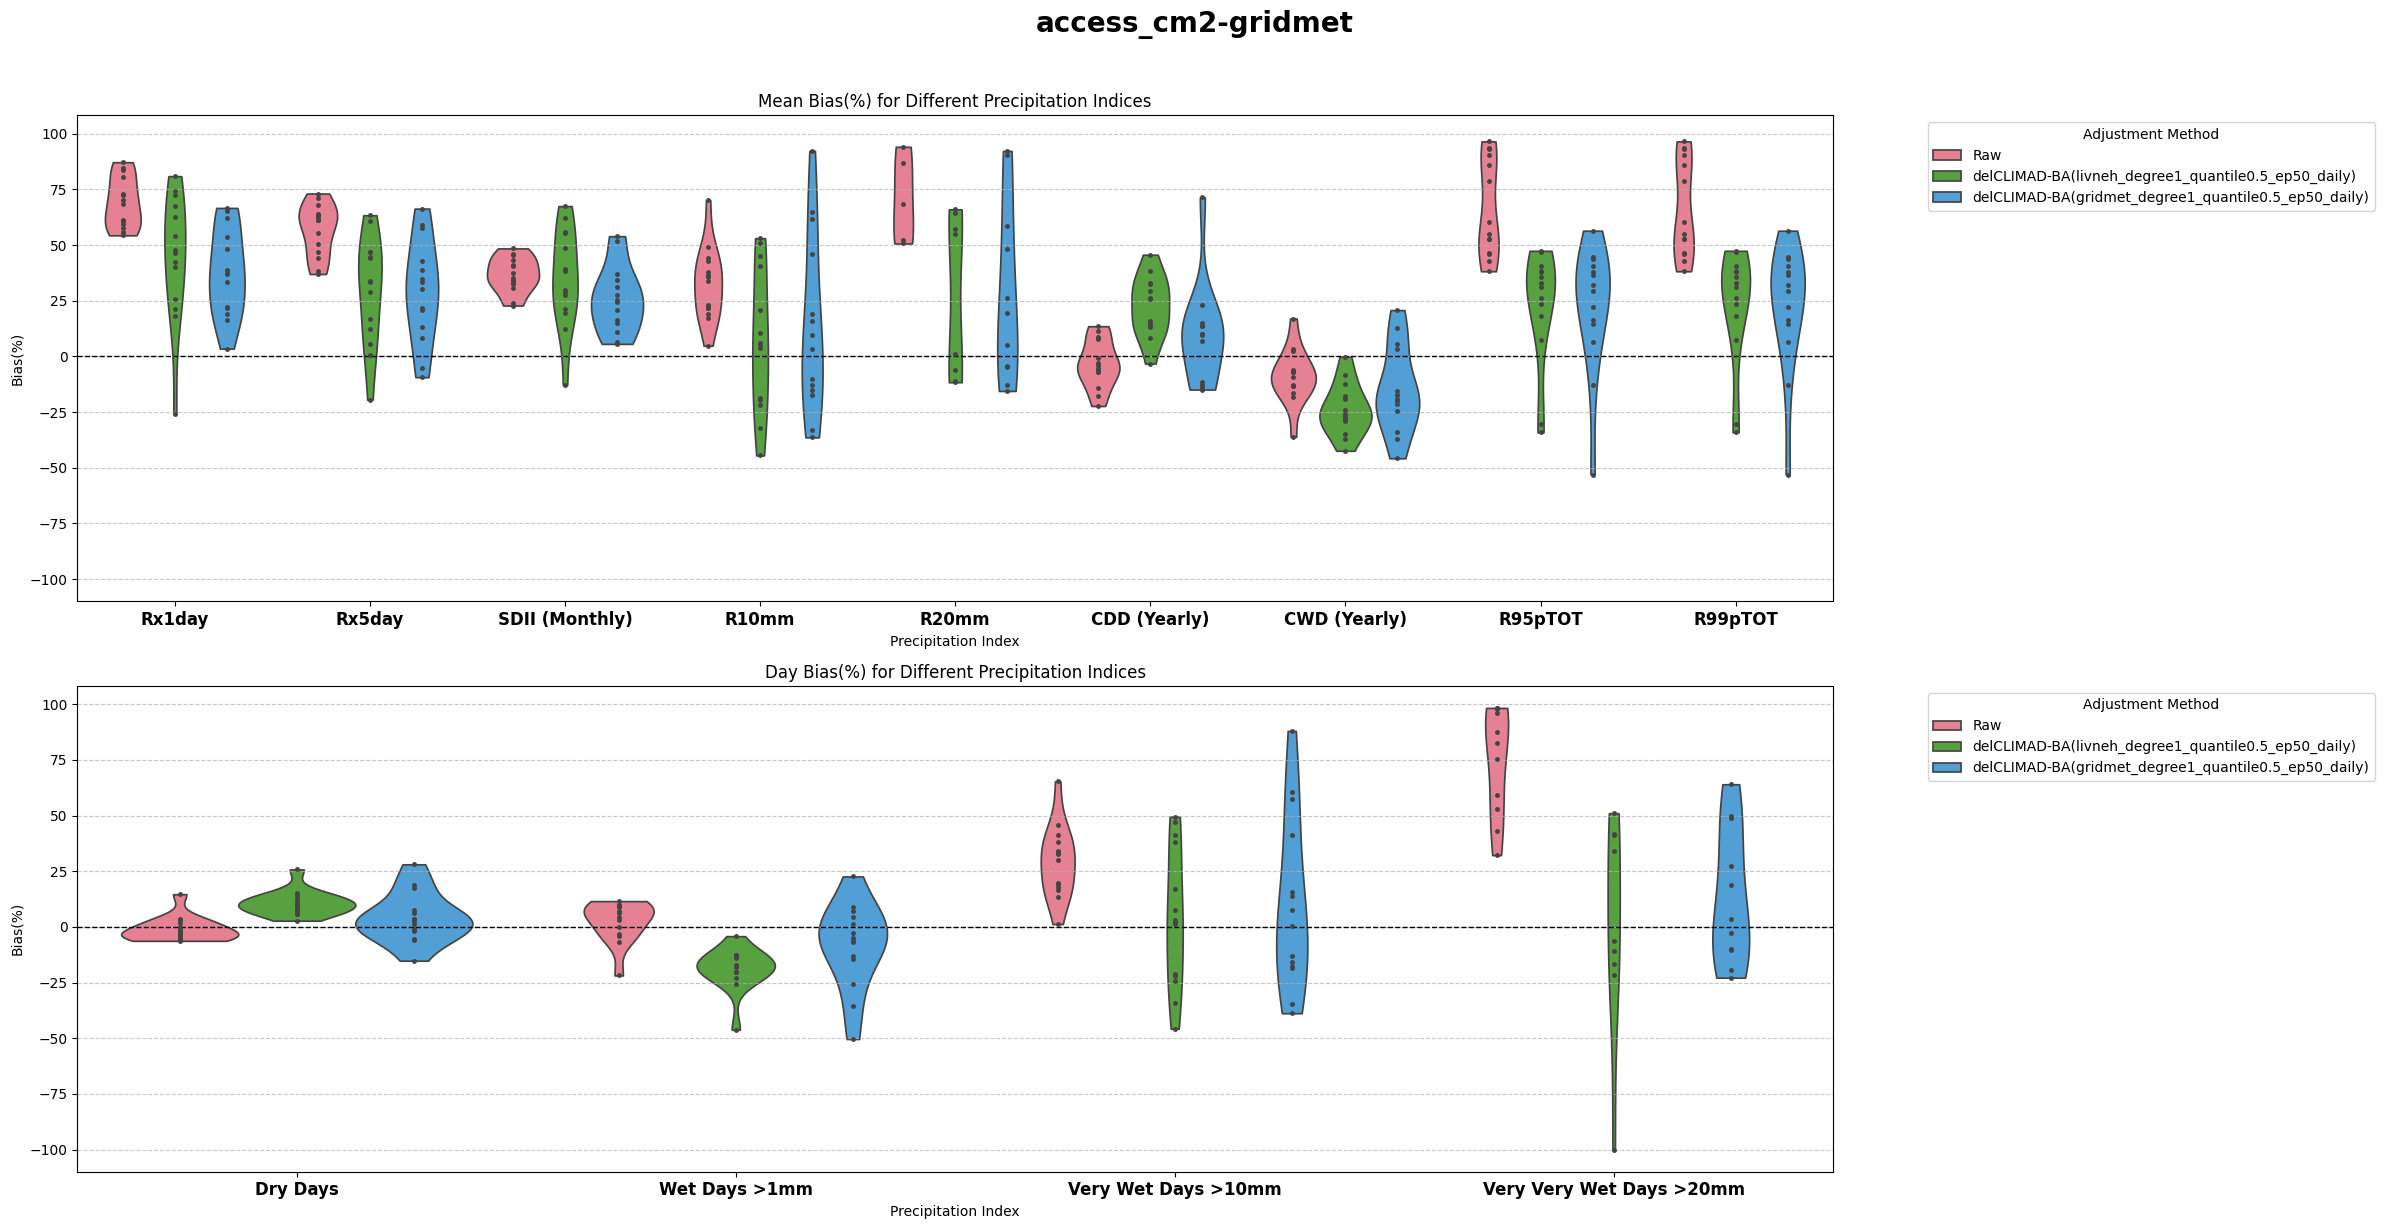

In [112]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , mean_bias_dict.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d4 = dict(filter(lambda item: item[0] in keys , day_bias_dict.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()

ref_label = models[exps.index(ref_eval)]['config']['ref']

# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", "Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}-{ref_label}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()

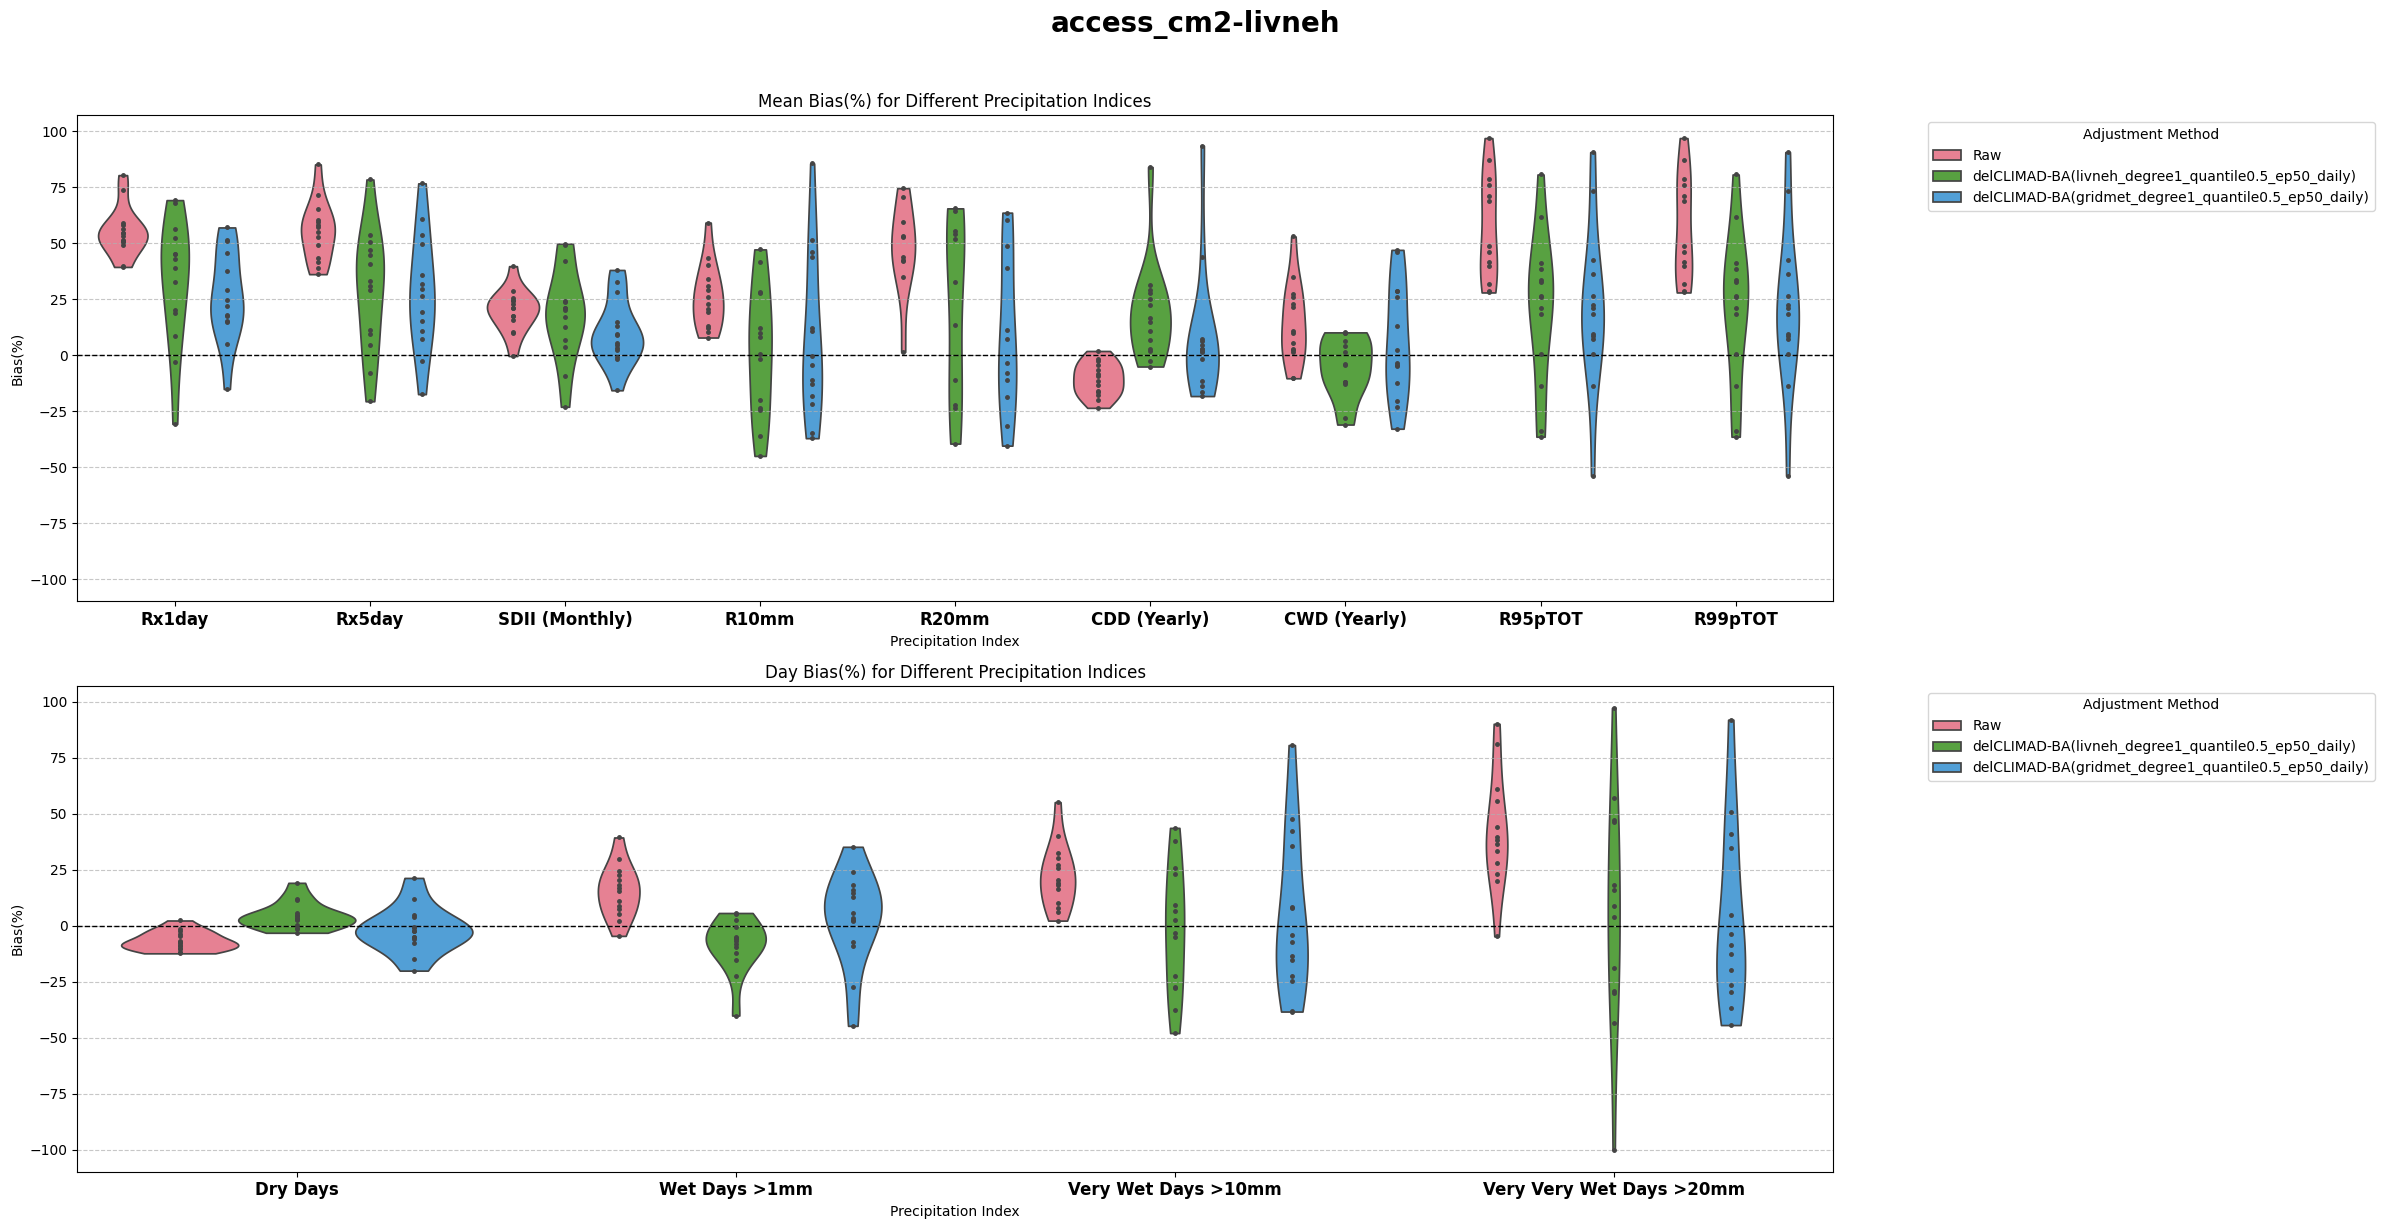

In [105]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , mean_bias_dict.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d4 = dict(filter(lambda item: item[0] in keys , day_bias_dict.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()

ref_label = models[exps.index(ref_eval)]['config']['ref']

# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", "Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}-{ref_label}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()

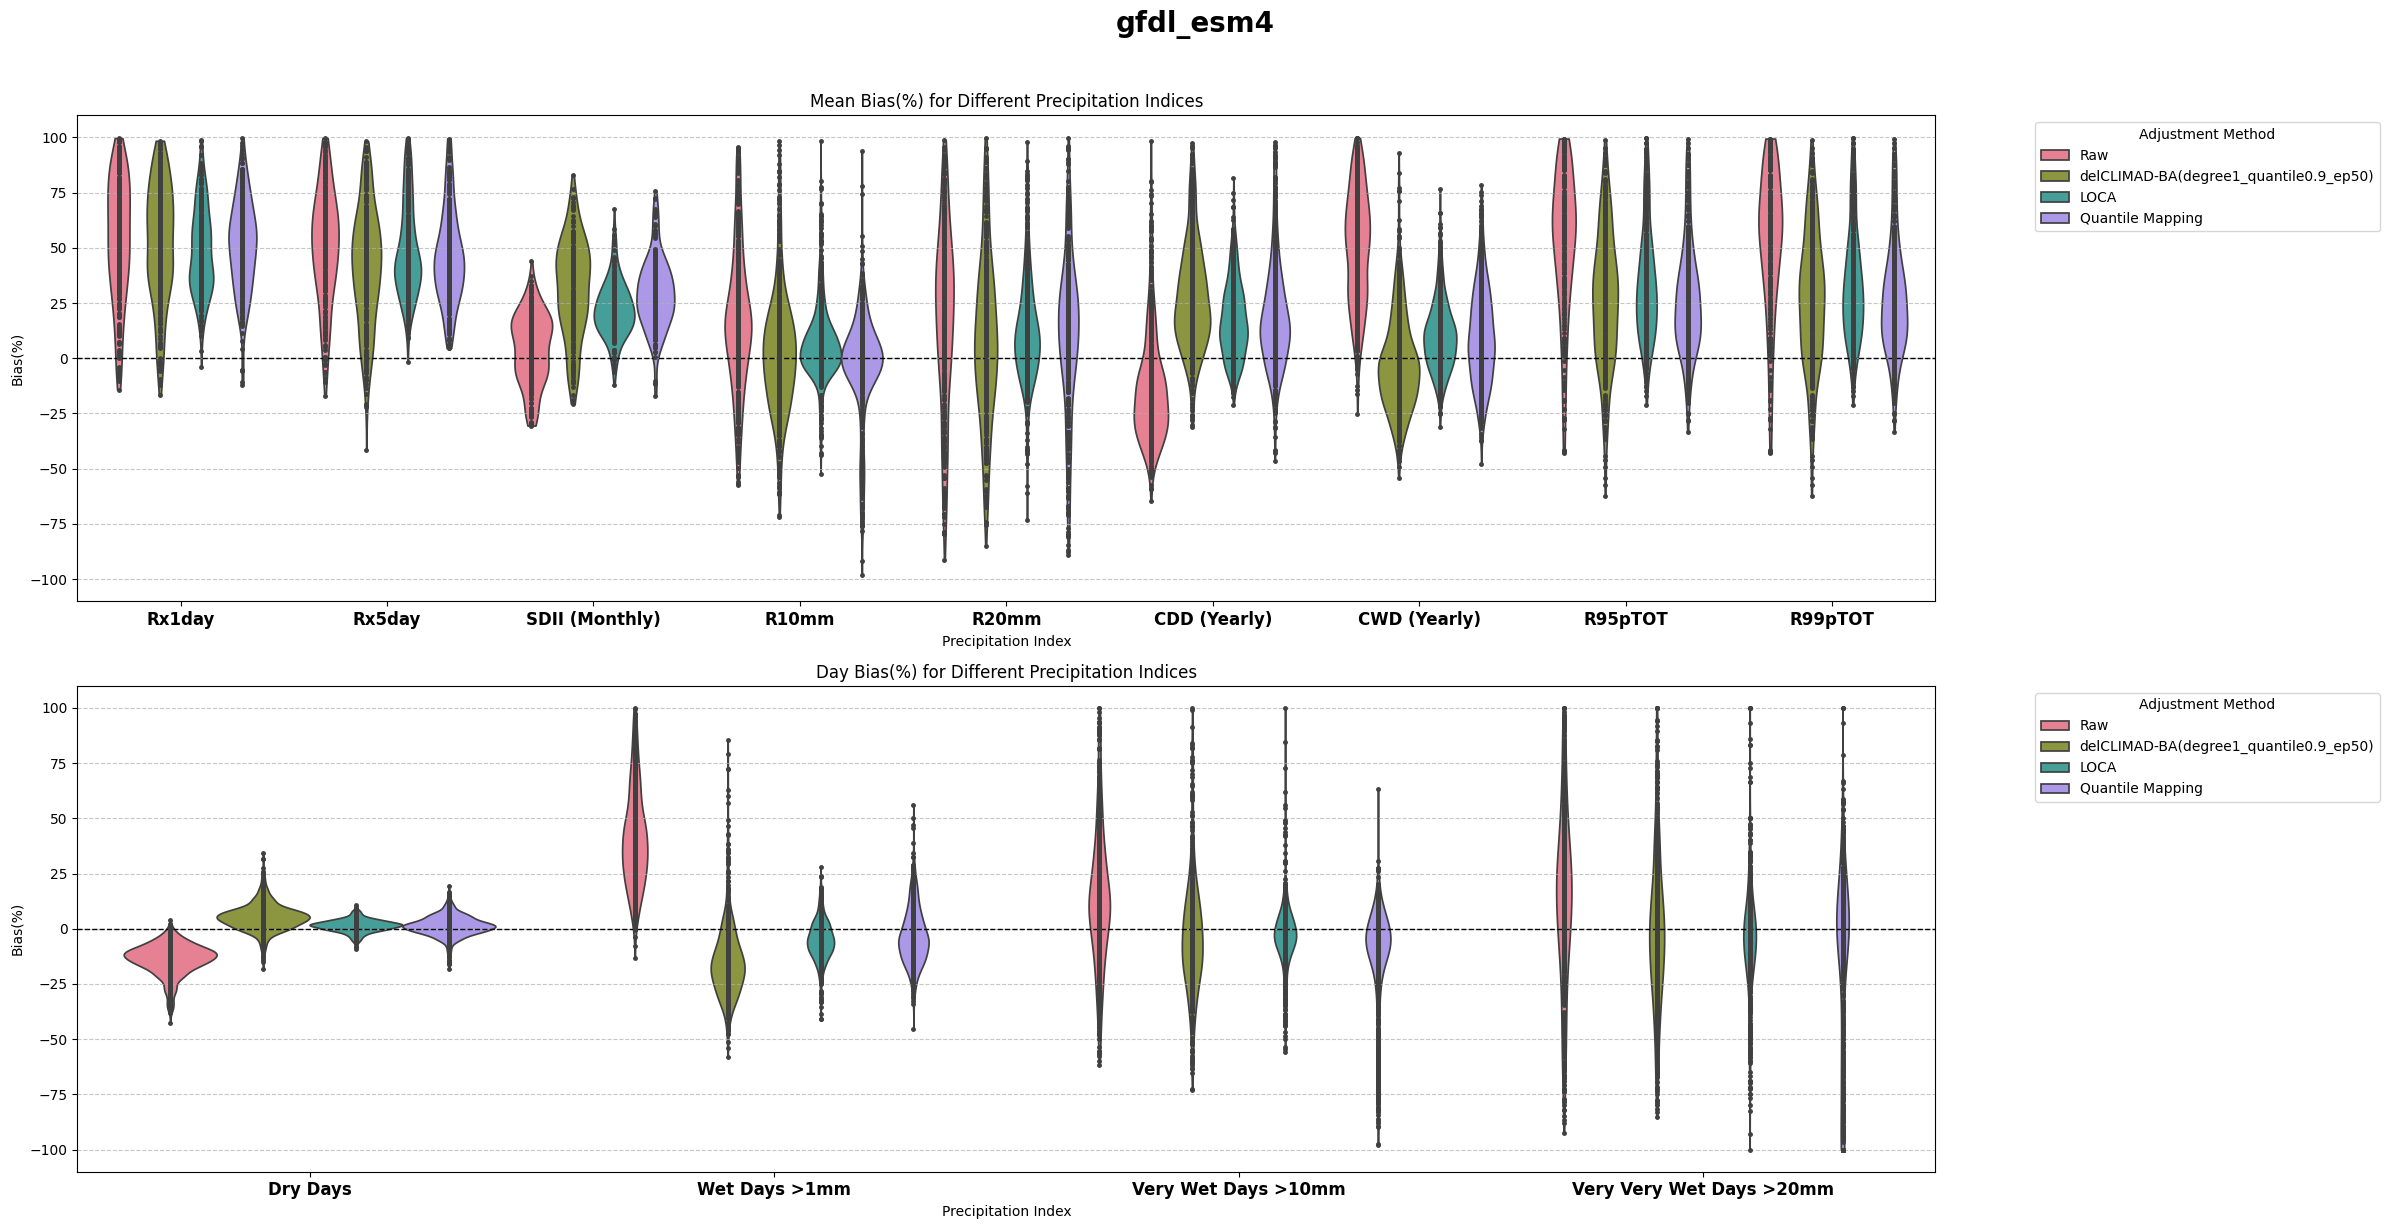

In [111]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , mean_bias_percentages.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d4 = dict(filter(lambda item: item[0] in keys , day_bias_percentages.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()
method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile}_ep{testep})", "LOCA", "Quantile Mapping"]


# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", "Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()

## Spatial Analysis

In [ ]:
threshold_types = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
method_names = ["delCLIMAD-BA", "LOCA"]

plot_spatial_bias(valid_coords=valid_coords,
                         bias_data_dict=day_bias_percentages,
                         threshold_types=threshold_types,
                         label="Bias Days %",
                         method_names=method_names,
                         vmin=-100,
                         vmax=100,
                         cmap="coolwarm")

In [ ]:
threshold_types = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
method_names = ["delCLIMAD-BA", "LOCA"]

plot_spatial_bias(valid_coords=valid_coords,
                         bias_data_dict=mean_bias_percentages,
                         threshold_types=threshold_types,
                         label="Mean Bias %",
                         method_names=method_names,
                         vmin=-100,
                         vmax=100,
                         cmap="coolwarm")

In [ ]:
# morans_i, p_value = compute_morans_i(mean_biases['Very Wet Days >10mm'][1], valid_coords)
# plot_moran_scatter(mean_biases['Very Wet Days >10mm'][1], valid_coords)


## Seasonal Analysis

In [ ]:
y_s = load_seasonal_data(x_time_np, y)
x_s = load_seasonal_data(x_time_np, x)
xt_s = load_seasonal_data(x_time_np, xt)

loca_s = load_seasonal_data(x_time_np, loca)
# QM_s = load_seasonal_data(x_time_np, QM_debiased)


t_s = load_seasonal_data(x_time_np, x_time_np)

In [ ]:
for season in ['Spring', 'Winter', 'Autumn', 'Summer']:
    x_s_s = x_s[season]
    y_s_s = y_s[season]
    xt_s_s = xt_s[season]
    loca_s_s = loca_s[season]
    t_s_s = t_s[season]

    seasonal_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, xt_s_s, climate_indices)
    seasonal_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, xt_s_s, t_s_s, climate_indices)
    seasonal_loca_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, loca_s_s, climate_indices)
    seasonal_loca_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, loca_s_s, t_s_s, climate_indices)

    ## Arranging delCLIMAD and LOCA in one dictionary
    for key in day_bias_percentages.keys():
        seasonal_day_bias_percentages[key] = seasonal_day_bias_percentages[key] + (seasonal_loca_day_bias_percentages[key][1],)


    for key in mean_bias_percentages.keys():
        seasonal_mean_bias_percentages[key] = seasonal_mean_bias_percentages[key] + (seasonal_loca_mean_bias_percentages[key][1],)



    keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
    d = dict(filter(lambda item: item[0] in keys , seasonal_mean_bias_percentages.items()))

    keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
    d2 = dict(filter(lambda item: item[0] in keys , seasonal_day_bias_percentages.items()))

    # Create a 2x2 subplot figure
    fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

    # Ensure axes is flattened for easy indexing
    axes = axes.flatten()
    method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile})", "LOCA"]


    # Call the function for each dataset
    plot_violin_bias(axes[0], d, "Bias(%)", f"Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

    plot_violin_bias(axes[1], d2, "Bias(%)", f"Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
    fig.suptitle(f'{clim}_{season}', fontsize=20, fontweight="bold", y=1.02)


    plt.tight_layout()
    plt.show()

In [ ]:
# Spring
season = 'Spring'
x_s_s = x_s[season]
y_s_s = y_s[season]
xt_s_s = xt_s[season]
loca_s_s = loca_s[season]
t_s_s = t_s[season]

seasonal_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, xt_s_s, climate_indices)
seasonal_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, xt_s_s, t_s_s, climate_indices)
seasonal_loca_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, loca_s_s, climate_indices)
seasonal_loca_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, loca_s_s, t_s_s, climate_indices)


## Arranging delCLIMAD and LOCA in one dictionary
for key in day_bias_percentages.keys():
    seasonal_day_bias_percentages[key] = seasonal_day_bias_percentages[key] + (seasonal_loca_day_bias_percentages[key][1],)


for key in mean_bias_percentages.keys():
    seasonal_mean_bias_percentages[key] = seasonal_mean_bias_percentages[key] + (seasonal_loca_mean_bias_percentages[key][1],)



keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , seasonal_mean_bias_percentages.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d2 = dict(filter(lambda item: item[0] in keys , seasonal_day_bias_percentages.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()
method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile})", "LOCA"]


# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", f"Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d2, "Bias(%)", f"Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}_{season}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()